In [1]:
%matplotlib inline
from __future__ import print_function

In [2]:
# If you have not installed the samwich package, e.g., using:
#   python setup.py install
# then we need to add the repo to our path.
import os,sys
sys.path.append(os.path.join(os.environ['HOME'],'waketracking'))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from samwich.dataloaders import planar_data
from samwich.waketrackers import track

# Wake Tracker Comparison
Written by [Eliot Quon](mailto:eliot.quon@nrel.gov) -- 2017-01-04

Instantaneous snapshot provided by [Paula Doubrawa](mailto:paula.doubrawa@nrel.gov)

In [4]:
trackerlist = track()

Need to specify 'method' as one of:
  ConstantArea (samwich.contour.ConstantAreaTracker)
  ConstantFlux (samwich.contour.ConstantFluxTracker)
  Gaussian2D (samwich.gaussian.Gaussian2DTracker)
  Gaussian (samwich.gaussian.GaussianTracker)
  CircularTestRegion (samwich.testregion.CircularTestRegionTracker)


## Case-specific parameters

In [5]:
#kind = 'mean'  # sanity check, not very interesting
kind = 'instantaneous'

In [6]:
D = 27.0  # to define the search range, and the reference area for the contour methods
zhub = 32.1  # hub height [m], for estimating the freestream reference velocity
aref = 0.3  # induction, for estimating the momentum theory mass/momentum flux

In [7]:
ref_area = np.pi*D**2/4
print(ref_area)

572.5552611167398


In [8]:
ref_CT = 4*aref*(1-aref)  # thrust coefficient
ref_CP = 4*aref*(1-aref)**2  # power coefficient
print(ref_CT,ref_CP)

0.84 0.5879999999999999


In [9]:
styles = {
    'gaussian (R)': {
        'label':r'1-D Gaussian ($\sigma=R$)',
        'color':'b',
        'linestyle':'--','linewidth':2,
        'marker':'o','markersize':6
    },
    'gaussian (1.5R)': {
        'label':r'1-D Gaussian ($\sigma=1.5R$)',
        'color':'m',
        'linestyle':'--','linewidth':2,
        'marker':'o','markersize':6
    },
    'gaussian (Porte-Agel)': {
        'label':r'1-D Gaussian (Porte-Agel model)',
        'color':'r',
        'linestyle':'--','linewidth':2,
        'marker':'o','markersize':6
    },
    'gaussian (ideal)': {
        'label':r'1-D Gaussian (x-mom deficit $\sigma$)',
        'color':'m',
        'linestyle':'--','linewidth':2,
        'marker':'o','markersize':6
    },
    'elliptical': {
        'label':r'2-D Gaussian (opt $\sigma_x$,$\sigma_y$,$\theta$)',
        'color':'y',
        'linestyle':'--','linewidth':2,
        'marker':'o','markersize':6
    },
    
    'const area': {
        'label':r'const area contour',
        'color':'b',
        'linestyle':'-','linewidth':2,
        'marker':'+','markersize':10
    },
    'momentum deficit': {
        'label':r'const x-mom deficit contour',
        'color':'r',
        'linestyle':'-','linewidth':2,
        'marker':'+','markersize':10
    },
    
    'min power': {
        'label':r'min power region',
        'color':'0.6',
        'linestyle':'-','linewidth':2,
        'marker':'x','markersize':8
    },
}

## Read in test data
Note: General dataloaders exist to handle processing of multiple sampling locations and/or many samples over time.

In [10]:
varlist = ['x','y','z','u','v','w']
sample = planar_data({v: np.loadtxt('MWE-data/3D_{}_{}_WFoR.txt'.format(kind,v)) for v in varlist})

## Calculate freestream
Note: This is an optional step if upstream data are available.

ref velocity (at z=32.1667) is 6.669858550736894


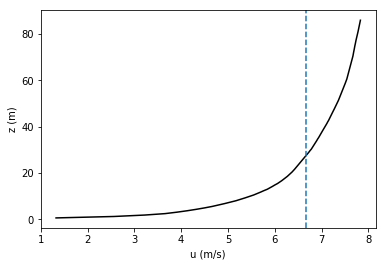

In [11]:
data = {v: np.loadtxt('MWE-data/freestream_mean_{}_WFoR.txt'.format(v)) for v in varlist}
free_z = data['z'][0,:]
free_Uprofile = np.mean(data['u'],axis=0)
jhub = np.argmin(np.abs(data['y'][:,0]-np.mean(data['y'][:,0])))
khub = np.argmin(np.abs(data['z'][0,:]-zhub))
ref_velocity = data['u'][jhub,khub]
#free_const = free_Uprofile*0.0 + ref_velocity

fig,ax = plt.subplots()
ax.plot(free_Uprofile,free_z,'-k')
ax.axvline(ref_velocity,linestyle='--')
plt.xlabel('u (m/s)')
plt.ylabel('z (m)')

print("ref velocity (at z={z}) is {Uref}".format(z=data['z'][0,khub],Uref=ref_velocity))

In [12]:
ref_thrust = ref_CT * 0.5*ref_velocity**2 * ref_area  # force / density
print('ref thrust (momentum deficit) is',ref_thrust,'N/(kg/m^3)')

ref thrust (momentum deficit) is 10697.93482558012 N/(kg/m^3)


## <font color='grey'>*Create all wake tracking objects at once*</font>

In [13]:
#
# CLEANER/CLEARER TO JUST CREATE THE TRACKER WITH EACH CASE
#
#for tracker in trackerlist:
#    wake[tracker] = track(sample.sliceI(),method=tracker,verbose=True) 
#    wake[tracker].remove_shear(wind_profile=free_Uprofile)

In [14]:
wake = {}
yc,zc = {},{}

## Constant area contours

In [15]:
tracker = 'const area'
wake[tracker] = track(sample.sliceI(),method='ConstantArea',verbose=True) 
wake[tracker].remove_shear(wind_profile=free_Uprofile)
yc[tracker],zc[tracker] = wake[tracker].find_centers(ref_area,
                                                     tol=0.01,  # min spacing to test (default:0.01)
                                                     verbosity=0,  # >0 for debugging
                                                    )  # center is weighted by velocity deficit by default

Slicing data at i=0 x=2495.7991314383826
Selected Tracker: ConstantArea

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 2495.7991314383817 0.001703044636769846 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96262213050795 58.96262213050795
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing waketracker

...finished initializing contourwaketracker

...finished initializing ConstantArea 

  subtracting out constant profile
Attempting to match area: 572.5552611167398 m^2


Processed frame 0


## Momentum deficit contours

In [16]:
tracker = 'momentum deficit'
#func = lambda u: u*(ref_velocity-u)  # this neglects shear
func = lambda u,u_tot: -u*u_tot  # == -(U(t,y,z) - U_inf(z))*U(t,y,z) == U*(U_inf - U)
wake[tracker] = track(sample.sliceI(),method='ConstantFlux',verbose=True) 
wake[tracker].remove_shear(wind_profile=free_Uprofile)
yc[tracker],zc[tracker] = wake[tracker].find_centers(ref_thrust,
                                                     flux_function=func,
                                                     #field_names=('u_tot'),  # instantaneous velocity
                                                     field_names=('u','u_tot'),
                                                     tol=0.01,  # min spacing to test (default:0.01)
                                                     verbosity=0,  # >0 for debugging
                                                    )  # center is weighted by velocity deficit by default

Slicing data at i=0 x=2495.7991314383826
Selected Tracker: ConstantFlux

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 2495.7991314383817 0.001703044636769846 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96262213050795 58.96262213050795
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing waketracker

...finished initializing contourwaketracker

...finished initializing ConstantFlux 

  subtracting out constant profile
Sample function evaluation: f(u=-4.8602190831835745,u_tot=0.38453) = 1.8689003187304745
Attempting to match integral: 10697.93482558012


Processed frame 0


## Gaussian Fits

In [17]:
tracker = 'gaussian (R)'
wake[tracker] = track(sample.sliceI(),method='Gaussian',verbose=True) 
wake[tracker].remove_shear(wind_profile=free_Uprofile)
yc[tracker],zc[tracker] = wake[tracker].find_centers(umin=None,  # default: detected from wake snapshot
                                                     sigma=D/2,
                                                    )  # center is weighted by velocity deficit by default

Slicing data at i=0 x=2495.7991314383826
Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 2495.7991314383817 0.001703044636769846 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96262213050795 58.96262213050795
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing waketracker

...finished initializing Gaussian 

  subtracting out constant profile
Calculated umin= [-4.86021908]
Average Gaussian function amplitude = -4.8602190831835745 m/s (over 1 times)
Specified Gaussian width = 13.5 m
Reference Gaussian area = 572.5552611167398 m^2


Processed frame 0


In [18]:
tracker = 'gaussian (Porte-Agel)'
from samwich.gaussian_functions import PorteAgel
#xref = np.mean(sample.x) - x0  # need to know turbine location...
xloc = 3*D  # samples 3D downstream

# model depends on case-dependent wake growth rate, kstar
fernando = PorteAgel(CT=ref_CT,d0=D,kstar=0.03) # ad-hoc value taken from Bastankhah & Porte-Agel 2014 (the smallest of the full-scale cases)
#fernando = PorteAgel(CT=ref_CT,d0=D,TI=0.20)

wake[tracker] = track(sample.sliceI(),method='Gaussian',verbose=True) 
wake[tracker].remove_shear(wind_profile=free_Uprofile)
yc[tracker],zc[tracker] = wake[tracker].find_centers(umin=fernando.amplitude(xloc,-ref_velocity),
                                                     sigma=fernando.sigma(xloc),
                                                    )  # center is weighted by velocity deficit by default

Slicing data at i=0 x=2495.7991314383826
Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 2495.7991314383817 0.001703044636769846 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96262213050795 58.96262213050795
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing waketracker

...finished initializing Gaussian 

  subtracting out constant profile
Calculated Gaussian width : 9.573528539874394 m
Calculated Gaussian amplitude : -3.961911603121127 m/s
Calculated Gaussian width : 9.573528539874394 m
Average Gaussian function amplitude = -3.961911603121127 m/s (over 1 times)
Specified Gaussian width = 9.573528539874394 m
Reference Gaussian area = 287.93465953134057 m^2


Processed frame 0


In [19]:
tracker = 'gaussian (ideal)' # sigma estimated from momentum deficit
wake[tracker] = track(sample.sliceI(),method='Gaussian',verbose=True) 
wake[tracker].remove_shear(wind_profile=free_Uprofile)

max_VD = -np.min(wake[tracker].u,axis=(1,2))  # max velocity deficit, u.shape == (Ntimes,Nh,Nv)
sigma_opt = np.sqrt(ref_thrust / (np.pi*max_VD*(2*ref_velocity - max_VD)))

yc[tracker],zc[tracker] = wake[tracker].find_centers(umin=None,  # default: detected from wake snapshot
                                                     sigma=sigma_opt,
                                                    )  # center is weighted by velocity deficit by default

Slicing data at i=0 x=2495.7991314383826
Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 2495.7991314383817 0.001703044636769846 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96262213050795 58.96262213050795
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing waketracker

...finished initializing Gaussian 

  subtracting out constant profile
Calculated umin= [-4.86021908]
Average Gaussian function amplitude = -4.8602190831835745 m/s (over 1 times)
Mean/min/max reference Gaussian area: 259.5816319251351 259.5816319251351 259.5816319251351 m^2


Processed frame 0


### 2D Gaussian

In [20]:
tracker = 'elliptical'
wake[tracker] = track(sample.sliceI(),method='Gaussian2D',verbose=True) 
wake[tracker].remove_shear(wind_profile=free_Uprofile)
yc[tracker],zc[tracker] = wake[tracker].find_centers(umin=None,  # default: detected from wake snapshot
                                                     A_min=ref_area/5.0,  # ad hoc value
                                                     A_max=ref_area*2.0,  # ad hoc value
                                                     AR_max=10.0,  # ad hoc value
                                                     verbosity=1,  # > 0 for debugging
                                                    )  # center is weighted by velocity deficit by default

Slicing data at i=0 x=2495.7991314383826
Selected Tracker: Gaussian2D

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 2495.7991314383817 0.001703044636769846 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96262213050795 58.96262213050795
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing waketracker

...finished initializing Gaussian2D 

  subtracting out constant profile
average Gaussian function amplitude = -4.8602190831835745 m/s (over 1 times)
yc,zc : -18.7, 37.9; rotation=-19.2504602242354 deg; ref wake area=286.5976358727009 m^2 (outline level=-0.6577591262146392)


Processed frame 0


## Test Region Approach

In [21]:
tracker = 'min power'
wake[tracker] = track(sample.sliceI(),method='CircularTestRegion',verbose=True) 
wake[tracker].remove_shear(wind_profile=free_Uprofile)
yc[tracker],zc[tracker] = wake[tracker].find_centers(test_radius=D/2,  # following Vollmer 2016
                                                     test_function=lambda u: u**3,
                                                     test_field='u_tot',
                                                     #verbosity=2,  # verbosity > 0 for debug output
                                                    )  # center is weighted by velocity deficit by default

Slicing data at i=0 x=2495.7991314383826
Selected Tracker: CircularTestRegion

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 2495.7991314383817 0.001703044636769846 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96262213050795 58.96262213050795
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing waketracker

...finished initializing CircularTestRegion 

  subtracting out constant profile
Searching within a region with radius=13.5


Processed frame 0


## Comparisons

In [22]:
itime = 0

In [23]:
for tracker,wakeobj in wake.items():
    print(tracker,'center at',(yc[tracker][itime],zc[tracker][itime]))

const area center at (-20.41292230318131, 37.994755447085005)
momentum deficit center at (-17.319626527133508, 36.59351687476402)
gaussian (R) center at (-17.571701367409343, 35.671083051326406)
gaussian (Porte-Agel) center at (-19.42868633670222, 37.972211014032816)
gaussian (ideal) center at (-19.794370277957693, 38.25317727690733)
elliptical center at (-18.722361889401395, 37.90280610418552)
min power center at (-20.691627581756233, 37.3569615663878)


In [24]:
all_yc = [ yc[tracker][itime] for tracker in wake.keys() ]
all_zc = [ zc[tracker][itime] for tracker in wake.keys() ]
yc_range = np.array([np.min(all_yc), np.max(all_yc)])
zc_range = np.array([np.min(all_zc), np.max(all_zc)])
print('y range:',yc_range,'==',yc_range/D,'D')
print('z range:',zc_range,'==',zc_range/D,'D')

y range: [-20.69162758 -17.31962653] == [-0.76635658 -0.64146765] D
z range: [35.67108305 38.25317728] == [1.32115122 1.41678434] D


### Compare all methods

Plotting const area const area contour
Plotting momentum deficit const x-mom deficit contour
Plotting gaussian (R) 1-D Gaussian ($\sigma=R$)
Plotting gaussian (Porte-Agel) 1-D Gaussian (Porte-Agel model)
Plotting gaussian (ideal) 1-D Gaussian (x-mom deficit $\sigma$)
Plotting elliptical 2-D Gaussian (opt $\sigma_x$,$\sigma_y$,$\theta$)
Plotting min power min power region


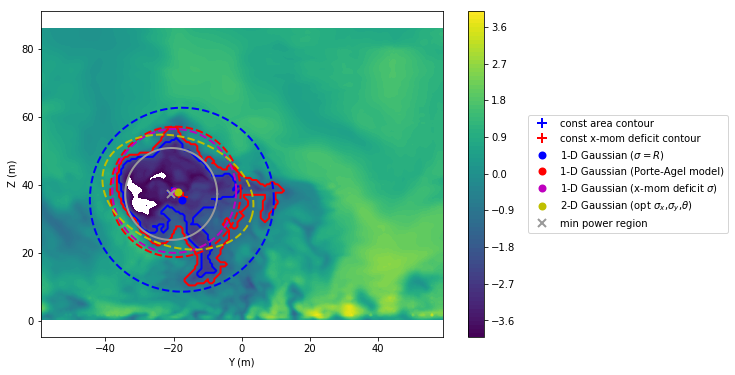

In [25]:
c1,c2,dc = -4, 4, 0.1 # for freestream profile

fig,ax = plt.subplots(figsize=(9,6))
p1 = ax.contourf(wake['const area'].xh[:,:],
                 wake['const area'].xv[:,:],
                 wake['const area'].u[0,:,:],levels=np.arange(c1,c2+dc,dc))
plt.colorbar(p1)
ax.set_xlabel('Y (m)')
ax.set_ylabel('Z (m)')

for tracker,wakeobj in wake.items():
    print('Plotting',tracker,styles[tracker]['label'])    
    ax.plot(yc[tracker][itime], zc[tracker][itime],
            color=styles[tracker]['color'],
            marker=styles[tracker]['marker'],linestyle='',
            ms=styles[tracker]['markersize'],mew=2,
            label=styles[tracker]['label'])
    ax.plot(wakeobj.paths[itime][:,0], wakeobj.paths[itime][:,1],
            color=styles[tracker]['color'],
            linestyle=styles[tracker]['linestyle'],
            linewidth=styles[tracker]['linewidth'])
plt.axis('equal')    
legend = ax.legend(loc='center left',bbox_to_anchor=(1.2,0.5),ncol=1)
plt.savefig('all_{:s}_wakes.png'.format(kind), dpi=150,
            bbox_extra_artists=(legend,), bbox_inches='tight')  # to handle outside legend

### Compare contour methods

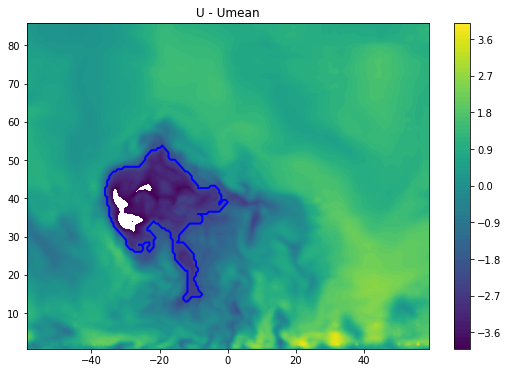

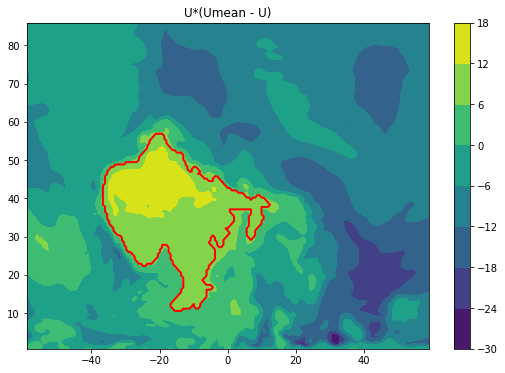

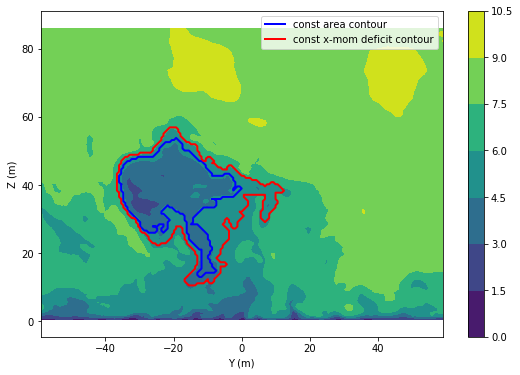

In [26]:
wakeobj = wake['const area']

fig,ax = plt.subplots(figsize=(9,6))
p1 = ax.contourf(wakeobj.xh[:,:],
                 wakeobj.xv[:,:],
                 wakeobj.u[0,:,:],levels=np.arange(c1,c2+dc,dc))
ax.plot(wake['const area'].paths[itime][:,0], wake['const area'].paths[itime][:,1],
        color=styles['const area']['color'],
        linestyle=styles['const area']['linestyle'],
        linewidth=styles['const area']['linewidth'])
plt.colorbar(p1)
ax.set_title('U - Umean')

fig,ax = plt.subplots(figsize=(9,6))
p1 = ax.contourf(wakeobj.xh[:,:],
                 wakeobj.xv[:,:],
                 -wakeobj.u[0,:,:]*wakeobj.u_tot[0,:,:])
ax.plot(wake['momentum deficit'].paths[itime][:,0], wake['momentum deficit'].paths[itime][:,1],
        color=styles['momentum deficit']['color'],
        linestyle=styles['momentum deficit']['linestyle'],
        linewidth=styles['momentum deficit']['linewidth'])
plt.colorbar(p1)
ax.set_title('U*(Umean - U)')

fig,ax = plt.subplots(figsize=(9,6))
p1 = ax.contourf(wakeobj.xh[:,:],
                 wakeobj.xv[:,:],
                 wakeobj.u_tot[0,:,:])
ax.plot(wake['const area'].paths[itime][:,0], wake['const area'].paths[itime][:,1],
        color=styles['const area']['color'],
        linestyle=styles['const area']['linestyle'],
        linewidth=styles['const area']['linewidth'],
        label=styles['const area']['label'])
ax.plot(wake['momentum deficit'].paths[itime][:,0], wake['momentum deficit'].paths[itime][:,1],
        color=styles['momentum deficit']['color'],
        linestyle=styles['momentum deficit']['linestyle'],
        linewidth=styles['momentum deficit']['linewidth'],
        label=styles['momentum deficit']['label'])
plt.colorbar(p1)
plt.axis('equal')
ax.legend(loc='best')
ax.set_xlabel('Y (m)')
ax.set_ylabel('Z (m)')
fig.savefig('compare_contour_{}.png'.format(kind),dpi=150)